In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import sklearn

In [ ]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

device_in_use='cpu'

# LOAD AND PROCESS DATA
**EXAMPLE WITH CA HOUSING DATASET**


In [ ]:
df = pd.read_csv('../datasets/income/adult.csv')


In [ ]:
df

In [ ]:
le = LabelEncoder()

In [ ]:
encoded_labels = le.fit_transform(df['income'])
y = pd.DataFrame(encoded_labels, columns=['income'])
X = df.drop(['income'], axis=1)

In [ ]:
def categorize_columns(dataframe):
    categorical_columns = []
    continuous_columns = []
    unique_classes_per_column = []  # To hold the number of unique classes for each categorical column

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) <= 10:
            # If the column's data type is 'object' or it has 10 or fewer unique values, consider it categorical.
            print('column', column)
            print('unique', len(dataframe[column].unique()))
            categorical_columns.append(column)
            unique_classes_per_column.append(dataframe[column].nunique())  # Store the number of unique classes
        else:
            # Otherwise, consider it continuous.
            continuous_columns.append(column)

    return categorical_columns, continuous_columns, unique_classes_per_column

cat_column, cont_columns, unique_classes_per_column = categorize_columns(X)
print(cat_column)
print(cont_columns)
print(unique_classes_per_column)
assert(len(cat_column) == len(unique_classes_per_column))

In [ ]:
# label encode all cat cols 

for col in cat_column: 
    X[col] = le.fit_transform(df[col])
    print(f"Min value in encoded {col}: {X[[col]].min()}")

In [ ]:
X


In [ ]:
data_types = X.dtypes
print(data_types)

X['workclass'].value_counts().unique()

In [ ]:
y

In [ ]:
X.columns

In [ ]:
# Set up k-fold cross-validation
kf = KFold(n_splits=5)

In [ ]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

In [ ]:
target = ['income']
#Getting the number of classes in your classification target per target
target_classes = [len(set(target))]

if target in cont_columns:
    cont_columns.remove(target)
elif target in cat_column:
    cat_column.remove(target)

# MODEL AND HELPERS

1. All you should have to do is interact with Classifier()

In [46]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.BCELoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_cont, cat_feat, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])
        # print('CAT FEAT', len(cat_feat))
        # print('CAT FEAT', cat_feat)
        # print('module list', len(self.cat_embeddings))



        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.cont_embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):
            # print(cat_x.shape)
            # print(i)
            goin_in = cat_x[:,i,:]
            # print(goin_in.shape)
            # print(f"Min: {goin_in.min()}, Max: {goin_in.max()}")
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
        x = self.sigmoid(x)
  
        return x

class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_cont = 0,
                 cat_feat:list = [],
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     embedding_dropout=embedding_dropout,n_cont=n_cont, cat_feat=cat_feat, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, cat_x, cont_x):
        class_embed, context = self.embeddings(cat_x, cont_x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        # print('task preds', task_predictions[0])
        # print('targs', labels_task1)

        loss = loss_function(task_predictions[0].squeeze(1), labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_prob_1 = task_predictions[0].squeeze(1)
        y_pred_labels_1 = (y_pred_prob_1 > 0.5).long()
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    print('total_correct', total_correct_1)
    print('total samples', total_samples_1)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions[0].squeeze(1), labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

# RUN EXPERIMENTS

1. Using Optuna to optimize CAT-Transformers hyperparameters for your dataset

In [ ]:
# Define the early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_metric = float('-inf')
        self.early_stop = False

    def __call__(self, metric):
        if metric > self.best_metric:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to log results to a text file
def log_to_file(filename, text):
    with open(filename, 'a') as f:
        f.write(text + '\n')

def objective(trial):
    trial_number = trial.number

    # Define hyperparameters to search over
    sigma = trial.suggest_categorical('sigma', [.001, 0.1, 1, 2, 3, 5, 10])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    # Ensure that embed_size is divisible by num_layers
    embed_size = trial.suggest_categorical("embed_size", [50, 60, 70, 80, 90, 100, 120, 140, 160])
    heads = trial.suggest_categorical("heads", [1, 5, 10])
    forward_expansion = trial.suggest_int('forward_expansion', 1, 8)
    prenorm_on = trial.suggest_categorical('prenorm_on', [True, False])
    mlp_scale_classification = trial.suggest_int('mlp_scale_classification', 1, 8)
    embedding_dropout = trial.suggest_categorical('embedding_dropout', [0, .1, .2, .5])
    decoder_dropout = trial.suggest_categorical('decoder_dropout', [0,.1,.2,.5])
    classification_dropout = trial.suggest_categorical('class_drop', [0,.1,.2,.5])

    learning_rate = trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.01])

    num_epochs = 75


    # Create your model with the sampled hyperparameters
    model = Classifier(
        n_features=len(cont_columns),
        targets_classes=[0],
        rff_on=True,
        sigma=sigma,
        embed_size=embed_size,
        num_layers=num_layers,
        heads=heads,
        forward_expansion=forward_expansion,
        pre_norm_on=prenorm_on,
        mlp_scale_classification=mlp_scale_classification,
        embedding_dropout=embedding_dropout,
        decoder_dropout=decoder_dropout,
        classification_dropout=classification_dropout
    ).to(device_in_use)

    # Define loss function and optimizer
    loss_function = UncertaintyLoss(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3)  # Adjust patience as needed

    # Training loop with a large number of epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy, _ = train(train_dataloader, model, loss_function, optimizer, device_in_use)
        
        # Validation loop
        val_loss, val_accuracy, _ = test(val_dataloader, model, loss_function, device_in_use)
        
        # Check if we should early stop based on validation accuracy
        if early_stopping(val_accuracy):
            break
    
    # Log the final test accuracy for this trial to a shared log file
    final_log = f"Trial {trial_number} completed. Validation Accuracy = {val_accuracy:.4f}"
    log_to_file('all_trials_log.txt', final_log)

    # Return the test accuracy as the objective to optimize
    return val_accuracy

In [ ]:
# Set the number of optimization trials
num_trials = 100

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize validation accuracy

# Start the optimization process
study.optimize(objective, n_trials=num_trials, show_progress_bar=True)

# Get the best hyperparameters and the validation accuracy at the point of early stopping
best_params = study.best_params
best_val_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy (at Early Stopping):", best_val_accuracy)

In [ ]:
X

In [ ]:
X['education'].value_counts()

FOLD  1
total_correct 21469
total samples 26048
Epoch [ 1/35]        | Train: Loss 0.3866, Accuracy 0.8242                               | Test: Loss 0.5811, Accuracy 0.5543, F1 0.3953
total_correct 22070
total samples 26048
Epoch [ 2/35]        | Train: Loss 0.3218, Accuracy 0.8473                               | Test: Loss 0.5500, Accuracy 0.5543, F1 0.3953
total_correct 22303
total samples 26048
Epoch [ 3/35]        | Train: Loss 0.3104, Accuracy 0.8562                               | Test: Loss 0.6078, Accuracy 0.5543, F1 0.3953
total_correct 22338
total samples 26048
Epoch [ 4/35]        | Train: Loss 0.3059, Accuracy 0.8576                               | Test: Loss 0.5539, Accuracy 0.5543, F1 0.3953
total_correct 22340
total samples 26048
Epoch [ 5/35]        | Train: Loss 0.3068, Accuracy 0.8576                               | Test: Loss 0.5207, Accuracy 0.5543, F1 0.3953
total_correct 22369
total samples 26048
Epoch [ 6/35]        | Train: Loss 0.3037, Accuracy 0.8588         

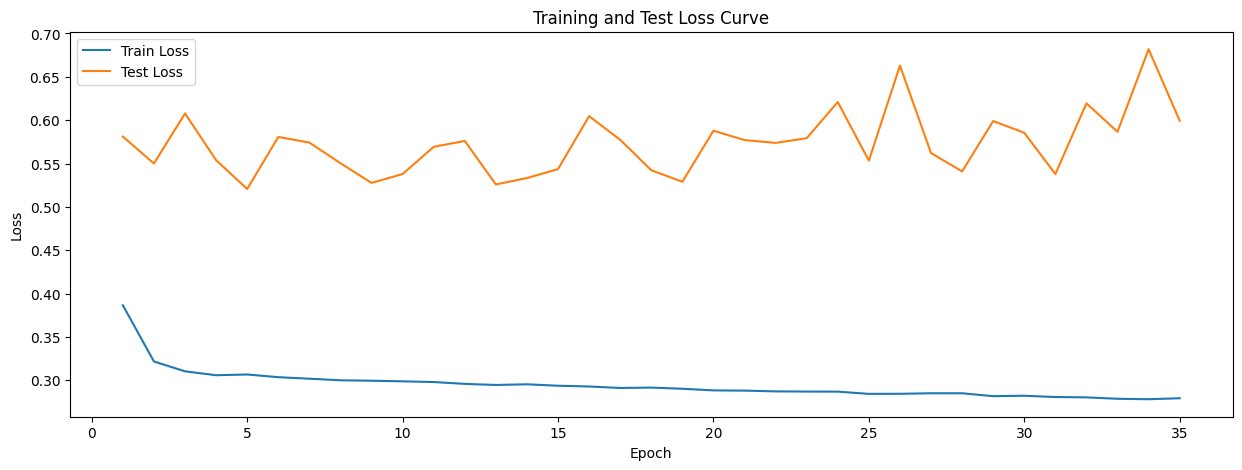

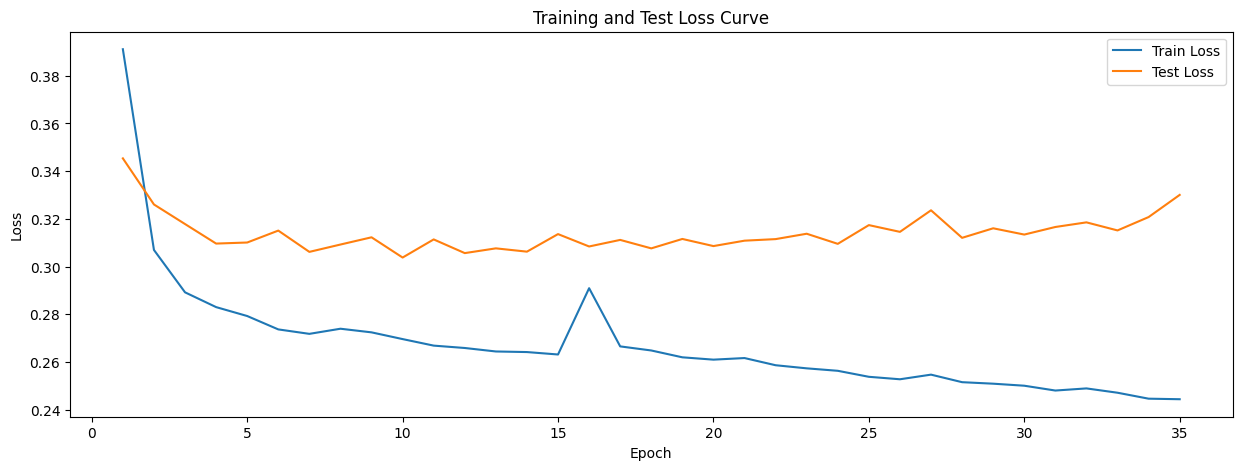

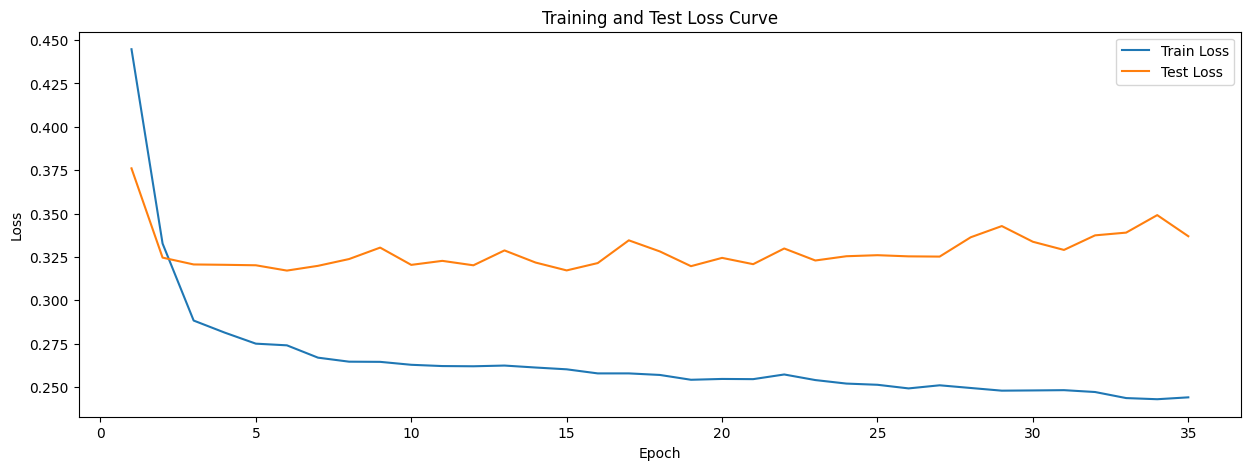

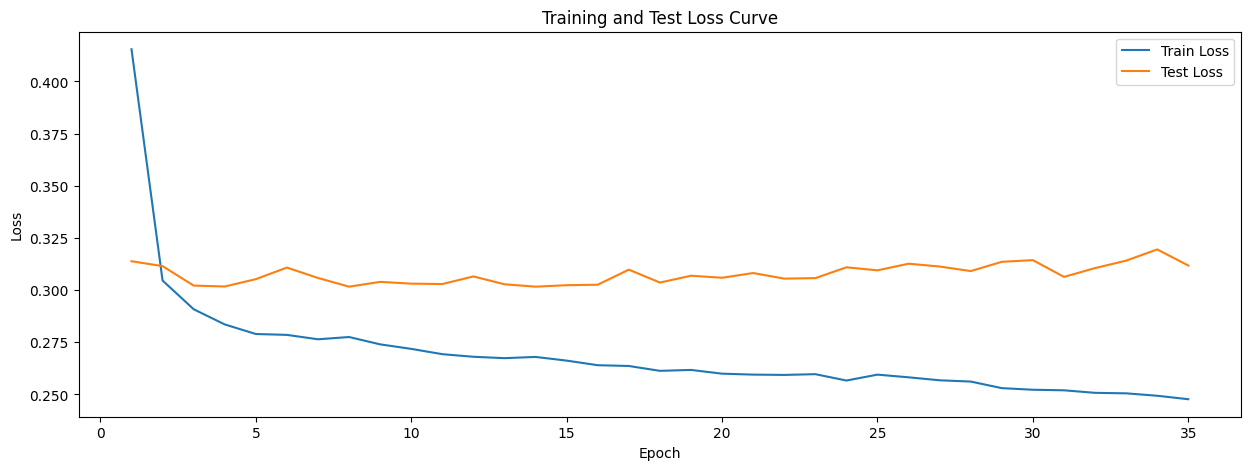

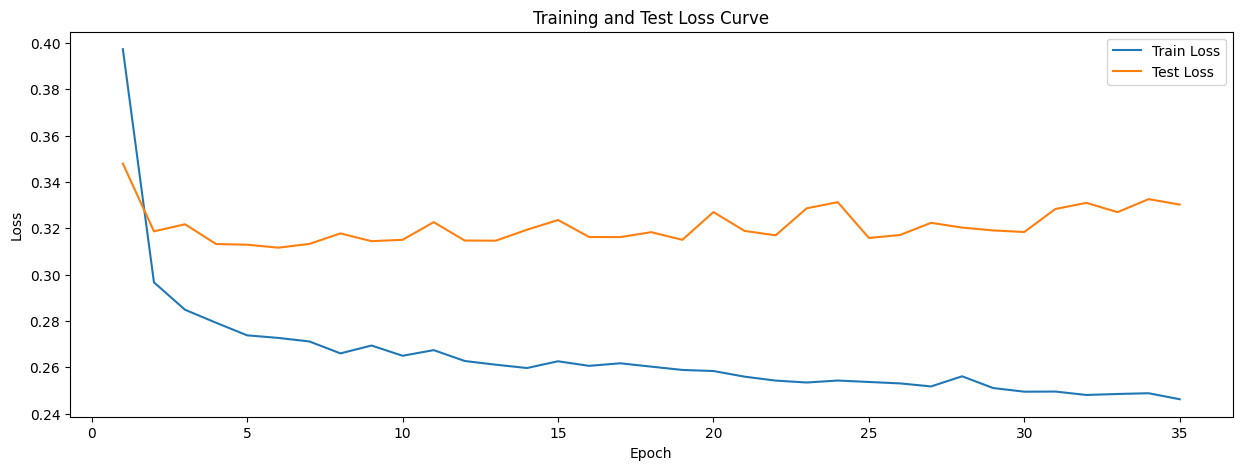

In [49]:


og_mean = 0
og_std = 0

fold = 0
for train_index, val_index in kf.split(X):

    stand = StandardScaler()

    # print(cont_columns)
    # print(cat_column)

    ct = ColumnTransformer(
        transformers=[
            ('stand', stand, cont_columns)  # ('name', transformer, columns)
        ],
        remainder='passthrough'  # Leave other columns unchanged
    )

    fold += 1
    print("FOLD ", fold)

    # initialize model, loss funct, and optimizer
    model = Classifier(
                   targets_classes=target_classes,
                   n_cont=len(cont_columns),
                   cat_feat=unique_classes_per_column,
                   rff_on=True,
                   sigma=4,
                   embed_size=100,
                   num_layers=1,
                   heads=1,
                   forward_expansion=1,
                   pre_norm_on=True,
                   mlp_scale_classification=8,
                   embedding_dropout=0,
                   decoder_dropout=0,
                   classification_dropout=0,
                   ).to(device_in_use) # Instantiate the model
    loss_functions = UncertaintyLoss(1)
    optimizer = torch.optim.Adam(params=model.parameters(), lr = .001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
    epochs = 35 #Set the number of epochs


    # Split data into training and validation sets using .iloc
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # print('XTRAIN', X_train[cat_column])
    # print(X_train.columns)

    # Create a new order for the columns where continuous columns come first (necessary for column tranformer)
    new_order = cont_columns + cat_column

    # Reorder the DataFrame columns using the new order
    X_train = X_train[new_order]
    X_val = X_val[new_order]

    # stardardize train values
    ct.fit(X_train)
    df_train_scaled = ct.transform(X_train)
    df_val_scaled = ct.transform(X_val)


    featurenames = ct.get_feature_names_out()
    print('feature names', featurenames)

    # print('transformed train', df_train_scaled)

    # create standardized dfs
    df_train = pd.DataFrame(df_train_scaled, columns=X_train.columns)
    df_val = pd.DataFrame(df_val_scaled, columns=X_val.columns)

    # print('XTRAIN AFTER CT' , df_train[cat_column])
    # print(df_train.columns)

    # recombine y_train and y_val to create dataloaders
    train_target=y_train.reset_index(drop=True)
    val_target=y_val.reset_index(drop=True)
    df_train['income'] = train_target
    df_val['income'] = val_target

    #Wrapping in Dataset
    train_dataset = SingleTaskDataset(df_train, cat_column, cont_columns, 'income')
    val_dataset = SingleTaskDataset(df_val, cat_column, cont_columns, 'income')

    # print(train_dataset[0])

    #This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
    #Also try looking to see what other papers have done
    batch_size = 256

    # Wrapping with DataLoader for easy batch extraction
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    #keep track of losses
    train_losses = []
    test_losses = []
    train_accuracies_1 = [] 
    test_accuracies_1 = []

    for t in range(epochs):
      train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
      test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(val_dataloader, model, loss_functions, device_in_use=device_in_use)
      train_losses.append(train_loss)
    #   print('accuracy', train_accuracy_1)
      train_accuracies_1.append(train_accuracy_1)

      # train_accuracies_2.append(train_accuracy_2)
      # train_recalls.append(train_recall) 
      # train_f1_scores.append(train_f1)
      test_losses.append(test_loss)
      test_accuracies_1.append(test_accuracy_1)
      # test_accuracies_2.append(test_accuracy_2)
      # test_recalls.append(test_recall)
      # test_f1_scores.append(test_f1)
      # Formatting for easier reading
      epoch_str = f"Epoch [{t+1:2}/{epochs}]"
      train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
      test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
      print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")


    # torch.save(model.state_dict(), 'final_model_trained.pth')

    # Plotting the loss curves
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 1, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Curve')
    plt.legend()


In [ ]:
print(sklearn.__version__)